In [129]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

%matplotlib inline

In [130]:
pixel_metric = 1 #parametr to be calculated in respect to marker size (cm/pixel)
marker_length = 3.6 #parametr to be in TextBox (Size of marker)

def grayscale(img):   
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):    
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def pixels_to_cm(pixels):
    return pixels * pixel_metric 

def pixels_to_cm2(pixels):
    return pixels * pixel_metric**2

def mean(numbers): #average from Vector 
    return int( sum(numbers) / max(len(numbers), 1) )

In [131]:
def is_circle(perimetr, area):
        if perimetr == 0:
            return False
        circularity = 4*math.pi*(area/(perimetr**2))
        if 0.7 < circularity < 1.2:
            return True
        return False
    
def is_square(polygon):
    (x, y, w, h) = cv2.boundingRect(polygon)    
    ar = w / float(h) 
    if ar >= 0.95 and ar <= 1.05:
        return True
    return False

def small_area(region): #check if object is too small
    return region < 50

In [203]:
def get_center(cont):     
    try:           
        M = cv2.moments(cont)
        cX = int((M["m10"] / M["m00"]))
        cY = int((M["m01"] / M["m00"]))   
        return (cX, cY)
    except ZeroDivisionError:
        return (0,0)
    
def get_perimetr(cont):
    return cv2.arcLength(cont, True)

def get_area(cont):
    return cv2.contourArea(cont)

def get_polygon(cont, perimetr):
    return cv2.approxPolyDP(cont, 0.04 * perimetr, True)

def get_shape_name(shape):    
    vc = len(shape.polygon)
    if vc == 2:
        return "line"    
    elif vc == 3:
        return "triangle"        
    elif vc == 4:  
        if is_square(shape.polygon):
            return "square"       
        return "rectangle"  
    elif vc == 5:
        return "pentagon" 
    elif vc == 6:
        return "hexagon"     
    elif vc == 7:
        return "heptagon" 
    elif vc >= 8: 
        if is_circle(shape.perimetr, shape.area ) == True:
            return "circle"
        elif vc == 8:
            return "octagon"
        elif vc == 9:
            return "nonagon"
        elif vc == 10:
            return "decagon"
        else:
            return "unidentified"
    else:
        return "unidentified"  
    
def get_bound_box(cont):
    return cv2.minAreaRect(cont) #center (x,y), (width, height), angle of rotation

def get_bound_circle(cnt):
    return cv2.minEnclosingCircle(cnt) #(x,y),radius 


In [201]:
def format_area(area):
    return "Area: " + "{:.2f}".format(pixels_to_cm2(area))
    
def format_length(length):
    return "Length: " + "{:.2f}".format(pixels_to_cm(length))

def format_dimensions(w, h):
    w_cm = pixels_to_cm(w)
    h_cm = pixels_to_cm(h)
    return "W: " + "{:.1f}".format(w_cm) +  " H: " + "{:.1f}".format(h_cm)

def format_radius(radius):
    return "Radius: " + "{:.2f}".format(pixels_to_cm(radius))

In [187]:
def draw_circle(image, cont, color=(0, 255, 0), thikness=2):
    (x,y),radius = get_bound_circle(cont) 
    cv2.circle(image, (int(x),int(y)), int(radius), color, thikness)
    
def draw_contours(image, cont, color=(0, 255, 0), thikness=2):
    cv2.drawContours(image, [cont], -1, color, thikness) 
    
def draw_angles(image, shape):
    angles = find_angles(shape)
    cont = shape.contour
    
    for par in angles:
        index, angle = par[0], par[1]
        cnt = cont[index][0]
        cv2.putText(image, str(int(angle)), (cnt[0], cnt[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0),1)

def draw_shape(image, shape, color=(0, 255, 0), thikness=2):      
    if shape.name == "circle": 
        draw_circle(image, shape.contour)       
    else:
        draw_contours(image, shape.polygon, color, thikness)            
    draw_angles(image, shape)        
        
def draw_shape_info(image, shape,color=(255, 0, 0), font=cv2.FONT_HERSHEY_SIMPLEX):
    cx, cy = shape.center[0], shape.center[1]   
    text = shape.info()
    dy = 15
    for line in text:     
        cv2.putText(image, line, (cx, cy), font, 0.5, color,1) 
        cy += dy

In [208]:
class Shape:
    def __init__(self, cont):
        self.contour = cont       
        
        self.center   = get_center(cont)         
        self.perimetr = get_perimetr(cont)
        self.polygon  = get_polygon(cont, self.perimetr) 
        self.area     = get_area(self.polygon)      
        
        self.name     = get_shape_name(self)        
        
        self.width  = 0
        self.height = 0           
    
    def __str__(self):
        return self.name
    
    def info(self):
        lines = [self.name]
        if  self.name != "line":
            lines.append(format_area(self.area))
            if self.name == "circle":
                (x,y),radius = get_bound_circle(self.contour)
                lines.append(format_radius(radius))
            else:
                bound_box = get_bound_box(self.contour)
                w,h = bound_box[1][0], bound_box[1][1]
                lines.append(format_dimensions(w,h))
        else:
            start, end = self.contour[0][0], self.contour[1][0]
            lines.append(format_length(self.perimetr / 2 )) #distanceP2P(start, end)
        return lines
    

In [136]:
SQUARE_PX = 60
COUNT = 7 #5
WIDTH = SQUARE_PX * COUNT
HEIGHT = SQUARE_PX * COUNT

def transform_matrix(polygon):
    if oriented_clockwise(polygon):
        # makes vector
        #[0 0]
        #[WIDTH, 0]
        #[WIDTH, HEIGHT]
        #....
        return np.float32([[0, 0], [WIDTH, 0], [WIDTH, HEIGHT], [0, HEIGHT]])
    else:
        return np.float32([[0, 0], [0, HEIGHT], [WIDTH, HEIGHT], [WIDTH, 0]])
    
def oriented_clockwise(polygon):
    
    #[1, 2] [3, 4] [5, 6]
    #-> [1, 3, 5] [2, 4, 6]
    x, y = map(np.squeeze, np.hsplit(np.squeeze(polygon), 2))  
    cross = (x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0])
    return cross > 0
    
def no_black_border(region):
    (h,w ) = region.shape[0], region.shape[1]
    offset = int(h / COUNT)
    l_offset = w - offset
    
    
    # calculates mean of 4 vectors :
    # 1 - region[0:offset, 0:w] x: from 0 to offset, y: from 0 to w
    mean = np.sum(map(np.mean, [region[0:offset, 0:w],
                                region[l_offset:w, 0:w],
                                region[0:w, 0:offset],
                                region[0:w, l_offset:w]]))
    return mean > 50




In [188]:
def draw_marker(image, marker):
    cx,cy = marker.center[0], marker.center[1]
    if marker is not None:
        cv2.drawContours(image, [marker.contour], -1, (250, 250, 0), 2) 
        size = pixels_to_cm(marker.perimetr / 4)
        cv2.putText(image, str(size), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (250, 250, 0),1) 
        
def draw_shapes(image, marker, shapes):
    for shape in shapes:
        if shape.name != "unidentified" and not intersect(marker, shape):
            draw_shape(image, shape)
            draw_shape_info(image, shape)
        
def draw_shapes_info(image, shapes):
    for shape in shapes:
        draw_shape_info(image, shape)

In [179]:
class Marker:
    def __init__(self, cont):
        self.contour = cont
        self.perimetr = get_perimetr(cont)
        self.center   = get_center(cont)
    
        

In [216]:
def detect_shapes(cnts):
    shapes = []        
    for c in cnts:        
        area = get_area(c)
        if small_area(area):
            continue
                
        shape = Shape(c)        
        shapes.append(shape)        
    return shapes

def big_enough(region):
    return small_area(cv2.contourArea(region))

def not_quadrilateral(points):
    return len(points) != 4

def detect_markers(blur):   
    __, thresh = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)
    _, contours, __ = cv2.findContours(thresh.copy(), cv2.RETR_TREE,
                                    cv2.CHAIN_APPROX_SIMPLE)
 

    for contour in contours:           
        if big_enough(contour):    
            continue
        
        perimetr = cv2.arcLength(contour, closed=True)
        eps = 0.08 * perimetr
        polygon = cv2.approxPolyDP(contour, eps, closed=True)
       
        if not_quadrilateral(polygon):         
            continue
      
        polygon_fl = np.float32(polygon)
        tr_matrix = transform_matrix(polygon)
        transform = cv2.getPerspectiveTransform(polygon_fl, tr_matrix)
       
        sq_marker = cv2.warpPerspective(thresh, transform, (WIDTH, HEIGHT))        
     
        if no_black_border(sq_marker):           
            continue
            
        return Marker(contour)
            
    return None


def get_box_points(cont):
    rect = get_bound_box(marker.contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return box

def intersect(marker, shape):    
    length = (marker.perimetr / 4)
    if distanceP2P(marker.center, shape.center) < length :
        return True
    return False  
    
    
        
def in_range(image, low, hight):
    return cv2.inRange(image, np.array([low]), np.array([hight]))

def find_countours(thresholded):
    image, countours, hierarchies = cv2.findContours(thresholded, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    return countours


In [176]:
def find_shapes(frame, low, high):
    gray     = grayscale(frame)
    blurred  = gaussian_blur(gray, 3)
    mask     = canny(blurred, low, high)
    mask     = gaussian_blur(mask, 15)    
    
    contours = find_countours(mask)
    shapes = detect_shapes(contours)
    
    markers = detect_markers(blurred)
    return shapes, markers

In [221]:
def nothing(x):
    pass

cap = cv2.VideoCapture(1)
ret, frame = cap.read()

avg1 = np.float32(frame)

count = 0
frame_offset = 3
low, high = 0, 255

shapes = []
marker = None

try:
    while(True):       
        ret, frame = cap.read()
    
        if ret == False:
            continue  
               
        if count < frame_offset:
            avg1 += frame
        else:
            count = 0          
            avg1 /= frame_offset
            res1 = cv2.convertScaleAbs(avg1)
            shapes, marker = find_shapes(res1, low, 110)
            avg1 = np.float32(frame)
            
        count+= 1 
        
        if marker is not None:
            if ( marker.perimetr > 0):
                per = marker.perimetr / 4
                pixel_metric = marker_length / per
                size = pixel_metric * per
                #cv2.putText(frame, str(size) + " " + str(marker.perimetr / 4), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (50, 255, 50),1) 
                draw_marker(frame, marker)
                draw_shapes(frame, marker, shapes)
        
      
        cv2.imshow('Frame',frame )
        
             
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
except KeyboardInterrupt:
    cap.release()
    cv2.destroyAllWindows()
    print ("Released")
except Exception as e :
    cap.release()
    cv2.destroyAllWindows()
    print (e)  

Released


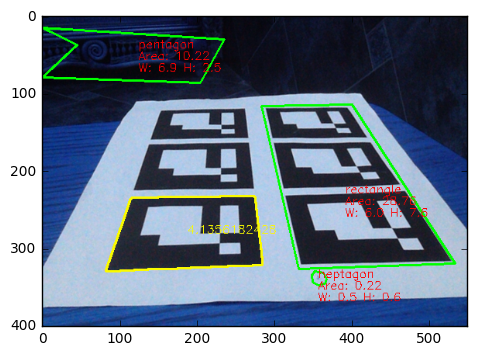

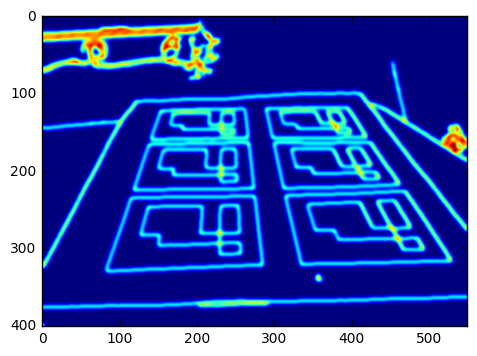

In [219]:
frame = cv2.imread('/home/taras/Pictures/test2.png', cv2.IMREAD_COLOR)

shapes, marker = find_shapes(frame, low, 110)


draw_marker(frame, marker)
draw_shapes (frame, marker, shapes)
#draw_shapes_info(frame, shapes)

plt.imshow(frame)
plt.show()

plt.imshow(mask)
plt.show()

In [10]:
def vector(a, b):
    return [a[0] - b[0], a[1] - b[1]]

def distance(vec):
    return (vec[0]**2 + vec[1]**2)**0.5

def distanceP2P(a, b):
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5

def dot(a, b):
    return a[0] * b[0] + a[1] * b[1]

def get_angle(start, far, end):
    
    a = vector(far, start)
    b = vector(far, end  )
    ab = dot(a, b)
    dist_ab = distance(a) * distance(b) 
    
    calc = min(max((ab / dist_ab), -1.0), 1.0)   
    
    angle = math.acos(calc) * 180 / math.pi
    return angle

def find_angles(shape):
    conts = shape.polygon  
    if shape.vertex_count < 3:
        return []
    
    angles = []    
    for i in range(shape.vertex_count):
        start  = conts[i][0]
        
        mid_index = i + 1
        if ( mid_index >= n ):
            mid_index = abs(mid_index - n)            
        target = conts[mid_index][0]
        
        end_index = i + 2
        if ( end_index >= n ):
            end_index = abs(end_index - n) 
        end    = conts[end_index][0]        
        
        angle = get_angle(start, target, end)
        
        angles.append([mid_index, angle])
        
    return angles
    

In [11]:
cap = cv2.VideoCapture(1)
calib = CameraCalib()
try:
    calib.calibrate(cap)
except KeyboardInterrupt:
    cap.release()
    cv2.destroyAllWindows()
    print ("Released")
except Exception as e :
    cap.release()
    cv2.destroyAllWindows()
    print (e) 
cap.release()
cv2.destroyAllWindows()

In [10]:
class CameraCalib:
    def __init__(self):
        self.criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.objp = np.zeros((6*7,3), np.float32)
        self.objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
        
        self.objpoints = [] # 3d point in real world space
        self.imgpoints = [] # 2d points in image plane
 
    def calibrate(self, cap):
        shape = (0, 0)
        ret, target = cap.read()
        count = 0
        while(count < 7):       
            ret, frame = cap.read()
    
            if ret == False:
                continue  
                
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            shape = gray.shape
            ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
        
            if ret == True and count < 7:
                target = frame.copy()
                self.objpoints.append(self.objp)
                
                corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),self.criteria)
            
                self.imgpoints.append(corners2)
                img = cv2.drawChessboardCorners(frame, (7,6), corners2,ret)
                count += 1
            
            cv2.imshow('Calibration',frame )   
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(self.objpoints, self.imgpoints,shape,None,None)
        
        h,  w = target.shape[:2]
        self.newcameramtx, roi=cv2.getOptimalNewCameraMatrix(self.mtx,self.dist,(w,h),1,(w,h))
    
    def undistort(self, frame):
        return cv2.undistort(frame, self.mtx, self.dist, None, self.newcameramtx)

In [64]:
frame = cv2.imread('/home/taras/Pictures/shapes2.png', cv2.IMREAD_COLOR)

with_shapes, _ = find_shapes(frame)

#plt.imshow(with_shapes)
#plt.show()

TypeError: find_shapes() takes exactly 3 arguments (1 given)

In [ ]:
    
        #if self.name = 
        
    
    #def getArea(self):
        #n = len(self.contour)
        #if n == 2:
            #return None
        #return "Area: " + str(int(pixels_to_cm2(self.area)))
    '''
    def getDimensions(self):
        n = len(self.contour)
        if n == 2:
            start, end = self.contour[0][0], self.contour[1][0]
            return "Length: " + str(int(pixels_to_cm(distanceP2P(start, end))))
        if n == 4:
            start, middle, end = self.contour[0][0], self.contour[1][0], self.contour[2][0]
            w, h = int(pixels_to_cm(distanceP2P(start, middle))), int(pixels_to_cm(distanceP2P(middle, end)))
            return "Width: " + str(w) + " Height: " + str(h)
        else:
            return None
    
    def draw(self, image):
        color = (0, 255, 0)
        thikness = 2
        if self.name == "circle":
            dists = [0]
            for pt in self.contour:
                dists.append(int(distanceP2P(self.center, pt[0])))
            cv2.circle(image, self.center, mean(dists), color, thikness)
        else:
            cv2.drawContours(image, [self.contour], -1, color, thikness)            
            draw_angles(image, self)
            
    def draw_info(self, image):
        color = (255, 0, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image, self.name, self.center, font, 0.5, color,1)
        
        dt = 15        
        dimesions = self.getDimensions()
        if  dimesions is not None:
            pt = (self.center[0],  self.center[1] + dt)
            cv2.putText(image, self.getDimensions(), pt, font, 0.5, color,1)       
            dt += 15
        
        pt = (self.center[0],  self.center[1] + dt)
        cv2.putText(image, self.getArea(), pt, font, 0.5, color,1)
    '''

In [ ]:
class ShapeDetector:
    def __init__(self):
        pass
 
    def detect(self, c, mask):
       
        shape = Shape()        
        shape.perimetr = cv2.arcLength(c, True)
        shape.contour  = cv2.approxPolyDP(c, 0.03 * shape.perimetr, True)
        shape.area     = cv2.contourArea(c)

        vertices_count = len(shape.contour)
        
        if vertices_count == 2:
            shape.name = "line" 
        elif vertices_count == 3:
            shape.name = "triangle"        
        elif vertices_count == 4:              
            if is_marker(shape, mask) == False:           
                (x, y, w, h) = cv2.boundingRect(shape.contour)
                ar = w / float(h)             
                shape.name = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"      
        elif vertices_count == 5:
            shape.name = "pentagon" 
        elif vertices_count == 6:
            shape.name = "hexagon" 
        elif vertices_count == 7:
            shape.name = "heptagon" 
        elif vertices_count >= 8: 
            if is_circle(shape.perimetr, shape.area ) == True:
                shape.name = "circle"
            elif vertices_count == 8:
                shape.name = "octagon"
            elif vertices_count == 9:
                shape.name = "nonagon"
            elif vertices_count == 10:
                shape.name = "decagon"
            else:
                shape.name = "unidentified"
                valid = False 
        else:
            shape.name = "unidentified"
            valid = False        
       
        return shape

In [ ]:
def draw_angles(image, shape):
    angles = find_angles(shape)
    cont = shape.contour
    
    for par in angles:
        index, angle = par[0], par[1]
        cnt = cont[index][0]
        cv2.putText(image, str(int(angle)), (cnt[0], cnt[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0),1)

def draw_shapes(image, shapes):
    color = (255, 0, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for shape in shapes:
        shape.draw(image)
        shape.draw_info(image)
        #cv2.drawContours(image, [shape.contour], -1, (0, 255, 0), 2)
        #cv2.putText(image, str(shape), shape.center, font, 0.5, color,1)
        
        #pt = (shape.center[0],  shape.center[1] + 15)
        #cv2.putText(image, shape.getDimensions(), pt, font, 0.5, color,1)
        
        #pt = (shape.center[0],  shape.center[1] + 30)
        #cv2.putText(image, shape.getArea(), pt, font, 0.5, color,1)
        
        #draw_angles(image, shape)
        

In [ ]:
'''
def is_marker(shape, thresh):
    #global metric_valid
    #if metric_valid == True:
        #return False
 
    polygon = shape.polygon
    polygon_fl = np.float32(polygon)
    tr_matrix = transform_matrix(polygon)
    transform = cv2.getPerspectiveTransform(polygon_fl, tr_matrix)
    
    sq_marker = cv2.warpPerspective(thresh, transform, (WIDTH, HEIGHT))  
    
    if no_black_border(sq_marker):           
        return False

    shape.name = "marker"
    #metric_valid = True
    #side_length = shape.perimetr / 4
    #pixel_metric = marker_length / side_length
    return True
'''

In [ ]:
''
def parse_marker(marker):
    marker_data = np.zeros(shape=(3, 3), dtype=np.int)

    squares = ((x, y, i, j)
               for i, x in enumerate(xrange(60, 181, 60))
               for j, y in enumerate(xrange(60, 181, 60)))

    for x, y, i, j in squares:
        if np.mean(marker[x:x+60, y:y+60]) > 200:
            marker_data[i, j] = 1

    return marker_data


def validate_marker(marker):
    valid_markers = ((marker_id, valid_marker, rotations)
                     for marker_id, valid_marker in VALID_MARKERS.iteritems()
                     for rotations in xrange(4))

    for marker_id, valid_marker, rotations in valid_markers:
        if np.array_equal(marker, np.rot90(valid_marker, rotations)):
            return True, marker_id, rotations

    return False, None, None

In [224]:
polygon = [[[1, 1]], [[2, 3]], [[3, 4]]]

x, y = map(np.squeeze, np.hsplit(np.squeeze(polygon), 2))  
print x, y
cross = (x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0])

[1 2 3] [1 3 4]
